## Interior Point Method from Scratch

References:
1. [Albers Uzila- Medium Article](https://towardsdatascience.com/how-to-solve-constrained-optimization-problem-the-interior-point-methods-1733095f9eb5)
2. [pyipm- IPM Class in Python](https://github.com/jkaardal/pyipm)
3. [mystic 0.4.0](https://pypi.org/project/mystic/)

In [1]:

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    '''Function to be minimized'''
    return (x[0]-5)**2 + (x[1]-6)**2

In [3]:

def g(x, t):
    '''Gradient of f(x) + 1/t * ϕ(x)'''

    x1, x2 = x
    
    dcdx1 = []
    dcdx1.append(2*x1 / (x1**2 - 4))
    dcdx1.append(-np.exp(-x1) / (np.exp(-x1) - x2))
    dcdx1.append(1 / (x1 + 2*x2 - 4))
    dcdx1.append(-1 / (-x1))
    dcdx1.append(0 / (-x2))
    
    dcdx2 = []
    dcdx2.append(0 / (x1**2 - 4))
    dcdx2.append(-1 / (np.exp(-x1) - x2))
    dcdx2.append(2 / (x1 + 2*x2 - 4))
    dcdx2.append(0 / (-x1))
    dcdx2.append(-1 / (-x2))
    
    dthetadx1 = 0
    dthetadx2 = 0
    for a, b in zip(dcdx1, dcdx2):
        dthetadx1 -= a
        dthetadx2 -= b
    
    grad = np.zeros(2)
    grad[0] = 2 * (x1-5) + 1/t * dthetadx1
    grad[1] = 2 * (x2-6) + 1/t * dthetadx2
    
    return grad

def H(x, t):
    '''Hessian of f(x) + 1/t * ϕ(x)'''
    
    x1, x2 = x
    
    terms = []
    terms.append(x1**2 - 4)
    terms.append(np.exp(-x1) - x2)
    terms.append(x1 + 2*x2 - 4)
    
    hess = np.zeros((2, 2))
    hess[0][0] = 2 - 1/t * ((-2 * x1**2 - 8)/(terms[0]**2) - \
                            (x2 * np.exp(-x1))/(terms[1]**2) - \
                            1/(terms[2]**2))
    
    hess[0][1] = -1/t * (-np.exp(-x1)/(terms[1]**2) - \
                         2/(terms[2]**2))
    
    hess[1][0] = hess[0][1]
    hess[1][1] = 2 - 1/t * (-1/(terms[1]**2) - 4/(terms[2]**2))
    
    return hess

In [4]:

def BarrierMethod(x_init, m, t, nu=0.01, tol_barrier=1e-5, tol_newton = 1e-5, max_iter=1000):
    '''Main algorithm for Barrier Method'''
    
    x = x_init               # store initial value
    xs = [x]                 # initialize tabulation of x for each iteration
    fs = [f(x)]              # initialize tabulation of function value at x
    duality_gap = [m/t]      # initialize tabulation of duality gap
    k = 0                    # number of iterations
    print(f'Initial condition: x = {x}, f(x) = {fs[k]:.4f}\n')

    # loop until stopping criterion is met
    while m / t > tol_barrier:
        # centering step: Newton Algorithm
        i = 0
        d = np.array([[1], [1]])
        while np.linalg.norm(d) > tol_newton and i < max_iter:
            gx = g(x, t)
            Hx = H(x, t)
            d = -np.dot(np.linalg.inv(Hx), gx)
            x = x + d
            xs.append(x)
            i += 1
        
        # update parameter t
        t = (1 + 1/(13 * np.sqrt(nu))) * t
        
        # update tabulations
        duality_gap.append(m/t)
        fs.append(f(x))
        k += 1
        
        # print result
        print(f'Iteration: {k} \t x = {x}, f(x) = {fs[k]:.4f}, gap = {duality_gap[k]:.4f}')
        
    xs = np.array(xs)
    return xs, fs, duality_gap

In [5]:

def plot_feasible_set(x, y):
    '''Plot feasible set to be color coded'''
    c1 = lambda a, b : a**2 - 4
    c2 = lambda a, b : np.exp(-a) - b
    c3 = lambda a, b : a + 2*b - 4
    c4 = lambda a, b : -a
    c5 = lambda a, b : -b
    plt.imshow(
        ((c1(x,y)<=0) & (c2(x,y)<=0) & (c3(x,y)<=0) & (c4(x,y)<=0) & (c5(x,y)<=0)).astype(int),
        extent=(x.min(),x.max(),y.min(),y.max()),
        origin='lower',
        cmap='inferno'
    )
    
def plot_contour(x_min, x_max, y_min, y_max):
    '''Plot contour of the objective function'''
    delta = 0.025
    x = np.arange(x_min, x_max, delta)
    y = np.arange(y_min, y_max, delta)
    x, y = np.meshgrid(x, y)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_coor = x[i][j]
            y_coor = y[i][j]
            z[i][j] = f(np.array([[x_coor], [y_coor]]))
    CS = plt.contour(x, y, z)
    plt.clabel(CS, fmt='%1.2f')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Contour of $f(x)$ along with the Feasible Set and Iteration Path')
    plt.show()
    
def plot_learning_curve(fx, duality_gap):
    '''Plot learning curve of the algorithm'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(fs, c='m')
    ax1.scatter(len(fs)-1, fs[-1], c='c')
    ax1.set(
        title='$f(x)$ for each Iteration',
        xlabel='Number of Iterations',
        ylabel='$f(x)$',
        xlim=0
    )
    ax2.plot(duality_gap, c='m')
    ax2.scatter(len(duality_gap)-1, duality_gap[-1], c='c')
    ax2.set(
        title='Duality Gap for each Iteration',
        xlabel='Number of Iterations',
        ylabel='Duality Gap',
        xlim=0
    )
    plt.show()
    
def plot_all(xs, fs, duality_gap):
    '''Plot all results'''
    
    plt.figure(figsize=(10, 10))
    plt.plot(xs[:,0], xs[:,1], 'm')
    plt.scatter(xs[-1][0], xs[-1][1], color='c')
    
    x_min, x_max = plt.gca().get_xlim()
    y_min, y_max = plt.gca().get_ylim()
    d = np.linspace(min(x_min, y_min, -0.25), max(x_max, y_max, 2.25), 2000)
    x, y = np.meshgrid(d, d)
    
    plot_feasible_set(x, y)
    plot_contour(x.min(), x.max(), y.min(), y.max())
    plot_learning_curve(fs, duality_gap)

Initial condition: x = [0.5  0.75], f(x) = 47.8125

Iteration: 1 	 x = [1.02021232 1.16420229], f(x) = 39.2236, gap = 28.2609
Iteration: 2 	 x = [1.10884556 1.17782113], f(x) = 38.3945, gap = 15.9735
Iteration: 3 	 x = [1.23572273 1.18154875], f(x) = 37.3873, gap = 9.0285
Iteration: 4 	 x = [1.38929174 1.16828641], f(x) = 36.3827, gap = 5.1031
Iteration: 5 	 x = [1.54412998 1.14080465], f(x) = 35.5548, gap = 2.8843
Iteration: 6 	 x = [1.67857545 1.10793827], f(x) = 34.9641, gap = 1.6303
Iteration: 7 	 x = [1.7837857  1.07707553], f(x) = 34.5792, gap = 0.9215
Iteration: 8 	 x = [1.86034225 1.05189637], f(x) = 34.3412, gap = 0.5208
Iteration: 9 	 x = [1.9129482 1.0332652], f(x) = 34.1983, gap = 0.2944
Iteration: 10 	 x = [1.94734433 1.02048913], f(x) = 34.1142, gap = 0.1664
Iteration: 11 	 x = [1.96888688 1.01224419], f(x) = 34.0654, gap = 0.0940
Iteration: 12 	 x = [1.98192052 1.00716369], f(x) = 34.0372, gap = 0.0532
Iteration: 13 	 x = [1.98960952 1.00413366], f(x) = 34.0211, gap = 0.

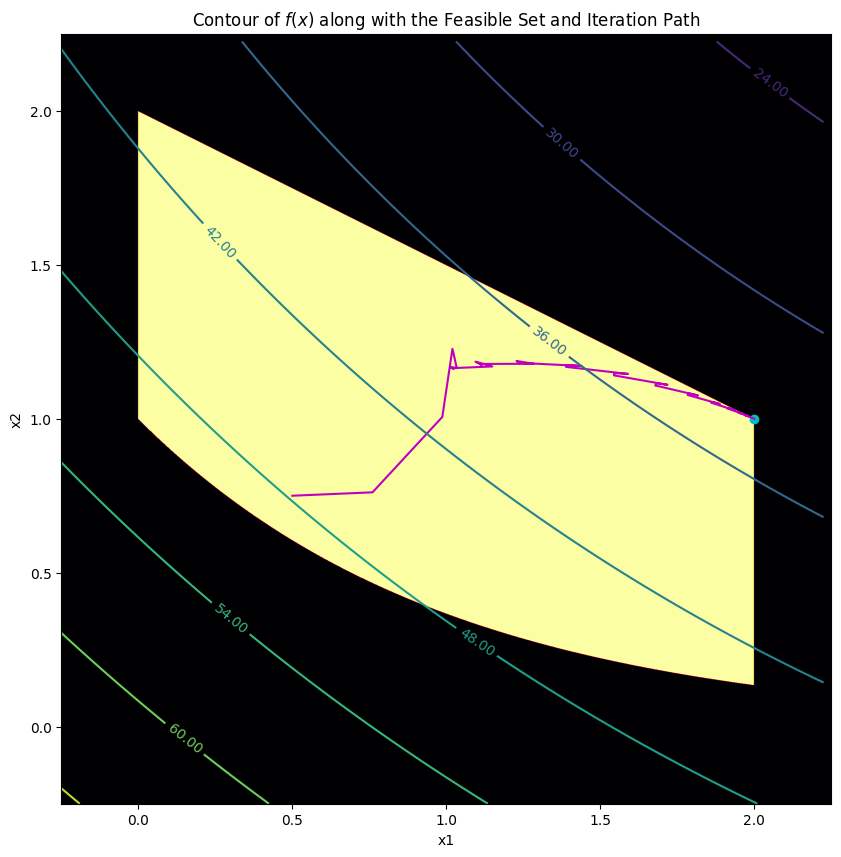

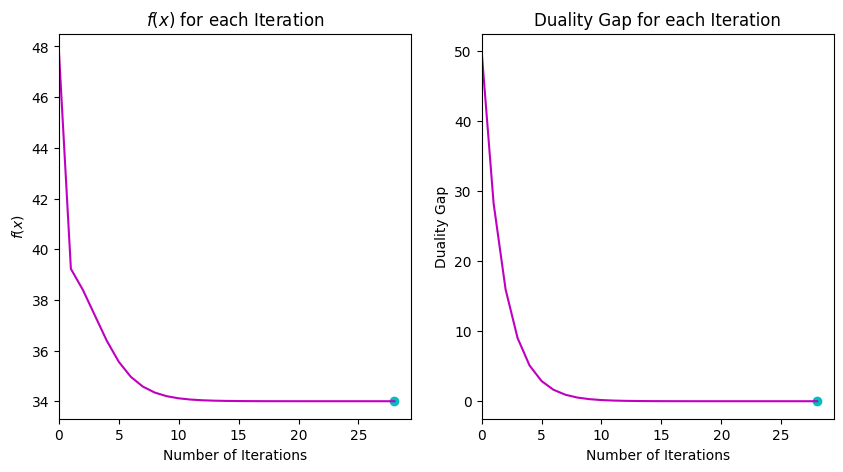

In [6]:

x_init = np.array([0.50, 0.75])
xs, fs, duality_gap = BarrierMethod(x_init, 5, 0.1)
plot_all(xs, fs, duality_gap)

Initial condition: x = [0.5  0.75], f(x) = 47.8125

Iteration: 1 	 x = [5.34749659 6.23289449], f(x) = 0.1750, gap = 2.8261
Iteration: 2 	 x = [5.20301538 6.13414137], f(x) = 0.0592, gap = 1.5974
Iteration: 3 	 x = [5.11709935 6.07667309], f(x) = 0.0196, gap = 0.9029
Iteration: 4 	 x = [5.06698948 6.04362062], f(x) = 0.0064, gap = 0.5103
Iteration: 5 	 x = [5.03813044 6.02474783], f(x) = 0.0021, gap = 0.2884
Iteration: 6 	 x = [5.02163921 6.01401791], f(x) = 0.0007, gap = 0.1630
Iteration: 7 	 x = [5.0122591  6.00793283], f(x) = 0.0002, gap = 0.0921
Iteration: 8 	 x = [5.00693814 6.00448687], f(x) = 0.0001, gap = 0.0521
Iteration: 9 	 x = [5.00392448 6.00253705], f(x) = 0.0000, gap = 0.0294
Iteration: 10 	 x = [5.00221912 6.0014343 ], f(x) = 0.0000, gap = 0.0166
Iteration: 11 	 x = [5.00125458 6.00081079], f(x) = 0.0000, gap = 0.0094
Iteration: 12 	 x = [5.00070921 6.00045831], f(x) = 0.0000, gap = 0.0053
Iteration: 13 	 x = [5.00040089 6.00025905], f(x) = 0.0000, gap = 0.0030
Iteratio

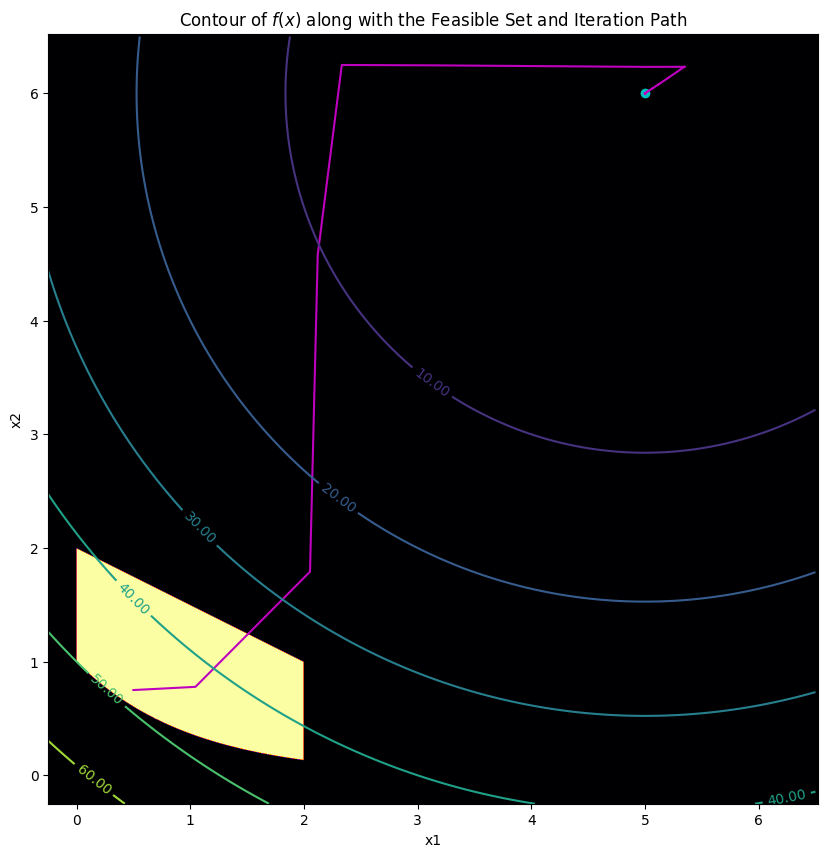

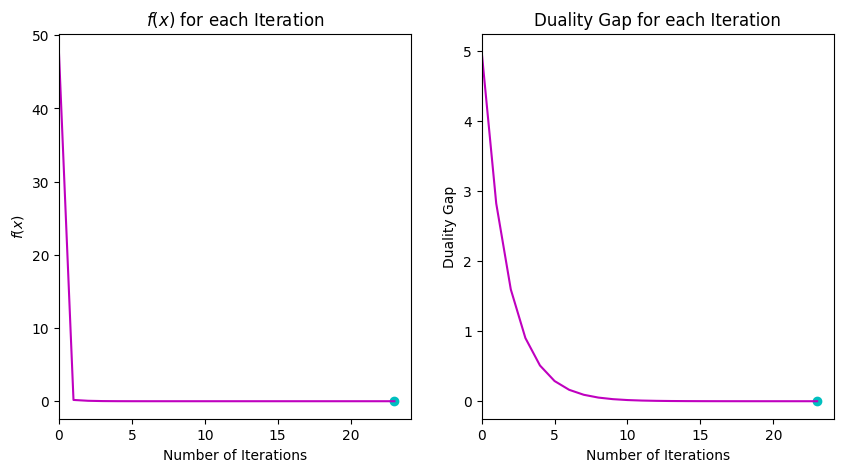

In [7]:

x_init = np.array([0.50, 0.75])
xs, fs, duality_gap = BarrierMethod(x_init, 5, 1)
plot_all(xs, fs, duality_gap)

Initial condition: x = [1.5 2. ], f(x) = 28.2500

Iteration: 1 	 x = [1.44403603 8.01008369], f(x) = 16.6853, gap = 28.2609
Iteration: 2 	 x = [1.55651102 7.25849435], f(x) = 13.4414, gap = 15.9735
Iteration: 3 	 x = [1.67419394 6.76420268], f(x) = 11.6450, gap = 9.0285
Iteration: 4 	 x = [1.77853972 6.45261496], f(x) = 10.5827, gap = 5.1031
Iteration: 5 	 x = [1.85865297 6.26330637], f(x) = 9.9374, gap = 2.8843
Iteration: 6 	 x = [1.91379545 6.15139478], f(x) = 9.5476, gap = 1.6303
Iteration: 7 	 x = [1.94898916 6.08642608], f(x) = 9.3161, gap = 0.9215
Iteration: 8 	 x = [1.97037968 6.04912901], f(x) = 9.1810, gap = 0.5208
Iteration: 9 	 x = [1.98299478 6.027859  ], f(x) = 9.1031, gap = 0.2944
Iteration: 10 	 x = [1.99030202 6.01577549], f(x) = 9.0585, gap = 0.1664
Iteration: 11 	 x = [1.99449054 6.00892591], f(x) = 9.0332, gap = 0.0940
Iteration: 12 	 x = [1.99687694 6.00504807], f(x) = 9.0188, gap = 0.0532
Iteration: 13 	 x = [1.9982319  6.00285421], f(x) = 9.0106, gap = 0.0300
Iter

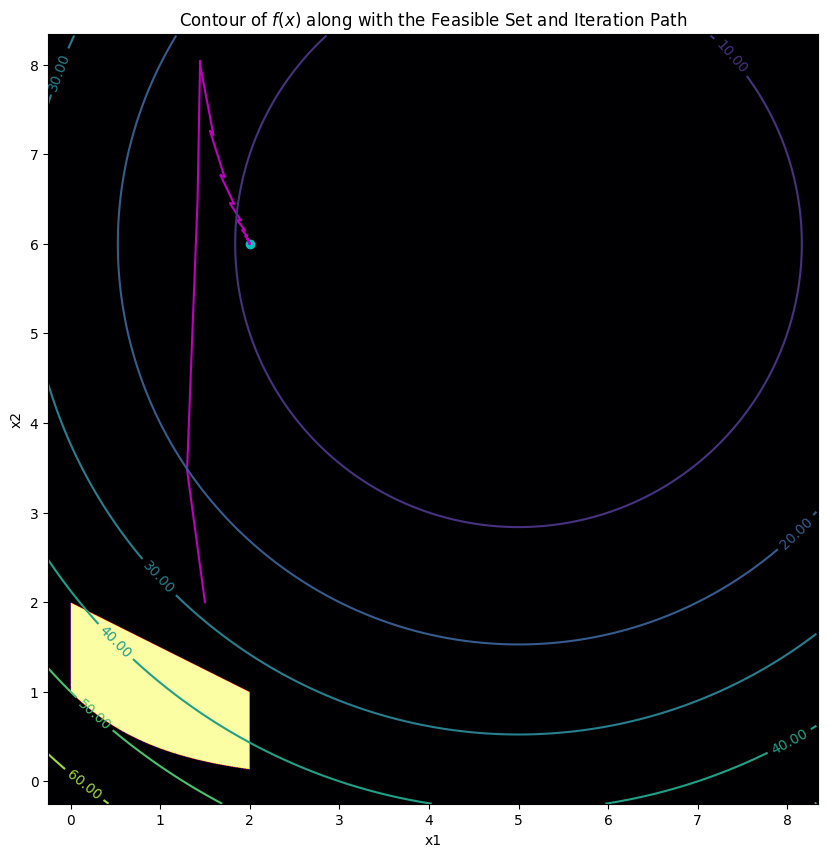

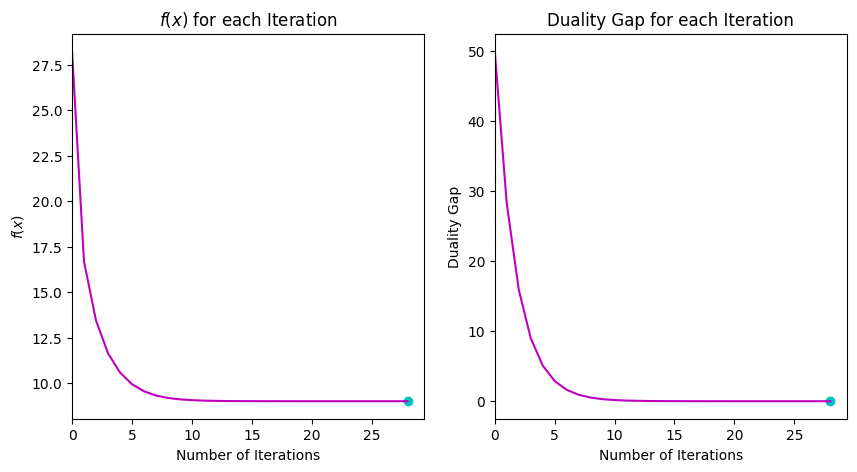

In [8]:

x_init = np.array([1.5, 2])
xs, fs, duality_gap = BarrierMethod(x_init, 5, 0.1)
plot_all(xs, fs, duality_gap)